Источник данных https://www.kaggle.com/datasets/timmate/avocado-prices-2020

# Продажи авокадо в США с 2015 по 2021 гг. 

### Некоторые соответствующие столбцы в наборе данных:  

**date** – дата наблюдения.  
**AveragePrice** — средняя цена одного авокадо.  
**type** – обычный или органический  
**year** - год  
**geography** - город или регион наблюдения  
**total value** – общее количество проданных авокадо.  
**4046** – Общее количество проданных авокадо с PLU 4046.  
**4225** — Общее количество проданных авокадо с PLU 4225.  
**4770** — Общее количество проданных авокадо с PLU 4770.  

In [3]:
# Библиотеки для обработки данных
import pandas as pd
import numpy as np

# Обработка предупреждений
import warnings

# База данных SQLite
import sqlite3

# Библиотека для работы со статистикой
import scipy.stats as st

# Библиотеки для визуализации данных
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', 200)

## Гипотезы:
1. В зимний период средняя цена авокадо выше (или меньше), чем в летний (зимний период: ноябрь - март, летний период: май - сентябрь).  
    **H0 - Цена относительно времени года не меняется.**  
    
    
2. Органических авокадо продается меньше, чем обычных.  
    **Н0 - Количество обычных авокадо продается столько же сколько и органических.**  
    
    
3. Калифорния закупает больше (или меньше авокадо) авокадо, чем Южная Каролина.  
    **Н0 - Калифорния закупает столько же, чем Южная Каролина.** 

## Подготовка данных

In [5]:
total_us = """SELECT date, average_price, total_volume, type_, location FROM main m
	LEFT JOIN "type" t ON m."type" = t.t_id 
	LEFT JOIN geography g ON m.geography  = g.g_id 
	LEFT JOIN location l ON g.type_of_location = l.l_id 
	WHERE location = 'country';"""

total_states = """SELECT date, average_price, total_volume, type_, geo, location FROM main m
	LEFT JOIN "type" t ON m."type" = t.t_id 
	LEFT JOIN geography g ON m.geography  = g.g_id 
	LEFT JOIN location l ON g.type_of_location = l.l_id 
	WHERE location = 'state';"""

In [18]:
data_total_us = pd.read_sql_query(total_us, sqlite3.connect('avocado.db'))
data_total_states = pd.read_sql_query(total_states, sqlite3.connect('avocado.db'))

In [19]:
data_total_us.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 612 entries, 0 to 611
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   date           612 non-null    object 
 1   average_price  612 non-null    float64
 2   total_volume   612 non-null    float64
 3   type_          612 non-null    object 
 4   location       612 non-null    object 
dtypes: float64(2), object(3)
memory usage: 24.0+ KB


In [44]:
data_total_us_with_dt = data_total_us.copy()
data_total_us_with_dt.date = pd.to_datetime(data_total_us_with_dt.date)

In [29]:
def solver(A, B):
    stat, p = st.ttest_ind(A, B)
    
    if p >= .05:
        return 'Н0 не отклоняем, средние, вероятно, одинаковы.'
    return 'Н0 отклоняем, средние, вероятно, разные.'

## Анализ признаков

In [31]:
data = data_total_us_with_dt[data_total_us_with_dt.type_ != 'organic']

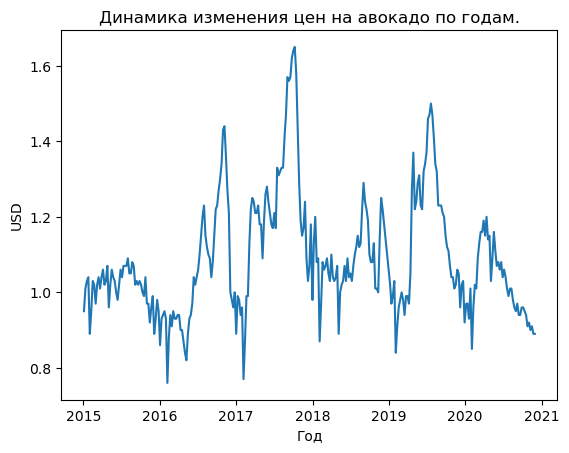

In [32]:
plt.plot(data.date, data.average_price)
plt.title('Динамика изменения цен на авокадо по годам.')
plt.ylabel('USD')
plt.xlabel('Год')
plt.show()

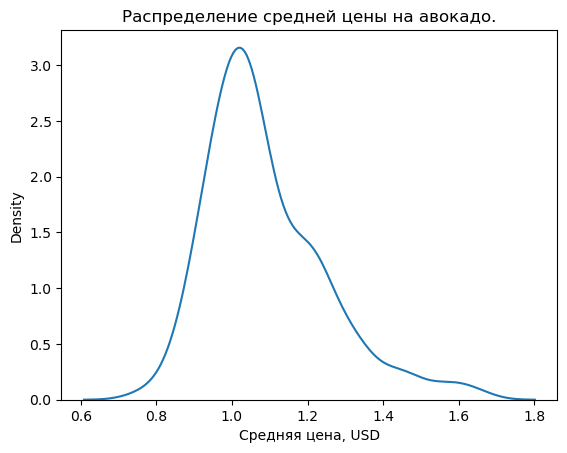

In [33]:
sns.kdeplot(data.average_price)
plt.title('Распределение средней цены на авокадо.')
plt.xlabel('Средняя цена, USD')
plt.show()

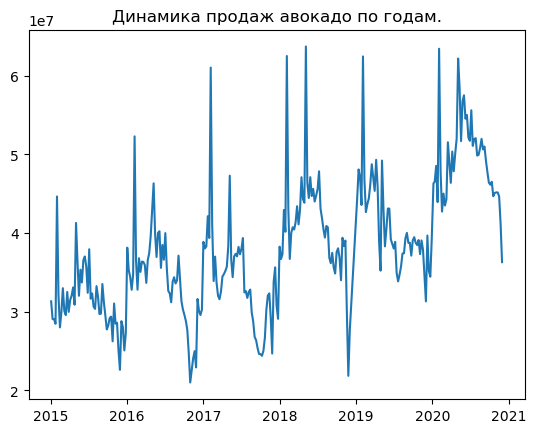

In [34]:
plt.plot(data.date, data.total_volume)
plt.title('Динамика продаж авокадо по годам.')
plt.show()

In [35]:
data_15 = data[(data.date >= '2016-01-01') & (data.date <= '2016-12-31')]

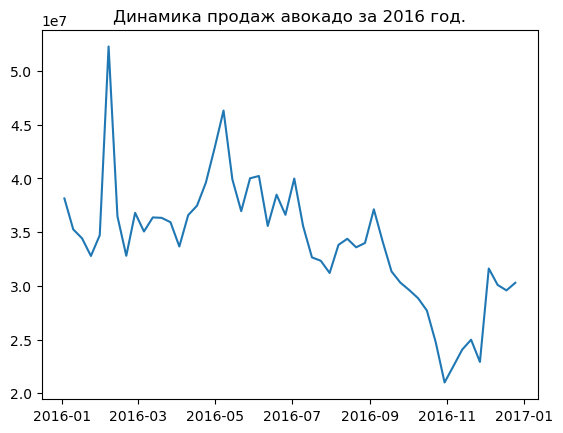

In [36]:
plt.plot(data_15.date, data_15.total_volume)
plt.title('Динамика продаж авокадо за 2016 год.')
plt.show()

### Проверка первой гипотезы:
В зимний период средняя цена авокадо выше, чем в летний (зимний период: ноябрь - март, летний период: май - сентябрь).

In [37]:
summer = data_total_us[(data_total_us.date >= '2015-05-01') & (data_total_us.date <= '2015-09-30') & 
                      (data_total_us.type_ != 'organic')]
for i in range(1, 7):
    summer = pd.concat([summer, data_total_us[(data_total_us.date >= f'201{5+i}-05-01') & (data_total_us.date <= f'201{5+i}-09-30') & 
                      (data_total_us.type_ != 'organic')]])

In [38]:
winter = data_total_us[(data_total_us.date >= '2015-11-01') & (data_total_us.date <= '2016-03-30') & 
                      (data_total_us.type_ != 'organic')]
for i in range(1, 7):
    winter = pd.concat([winter, data_total_us[(data_total_us.date >= f'201{5+i}-11-01') & (data_total_us.date <= f'201{6+i}-03-30') & 
                      (data_total_us.type_ != 'organic')]])

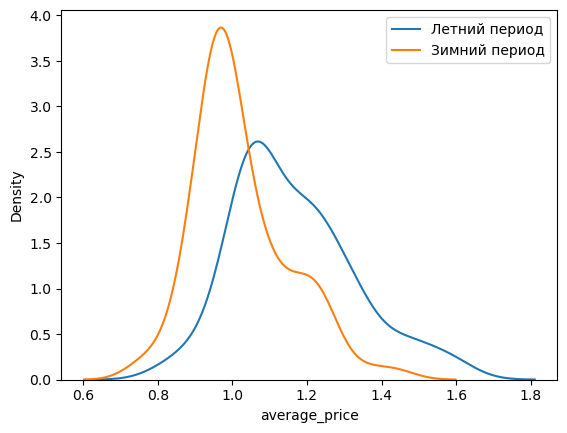

In [39]:
sns.kdeplot(summer.average_price, label='Летний период')
sns.kdeplot(winter.average_price, label='Зимний период')
plt.legend()
plt.show()

In [40]:
solver(summer.average_price, winter.average_price)

'Н0 отклоняем, средние, вероятно, разные.'

### Проверка второй гипотезы
Органических авокадо продается меньше, чем обычных.

In [41]:
organic = data_total_us[data_total_us.type_ == 'organic']
conventional = data_total_us[data_total_us.type_ == 'conventional']

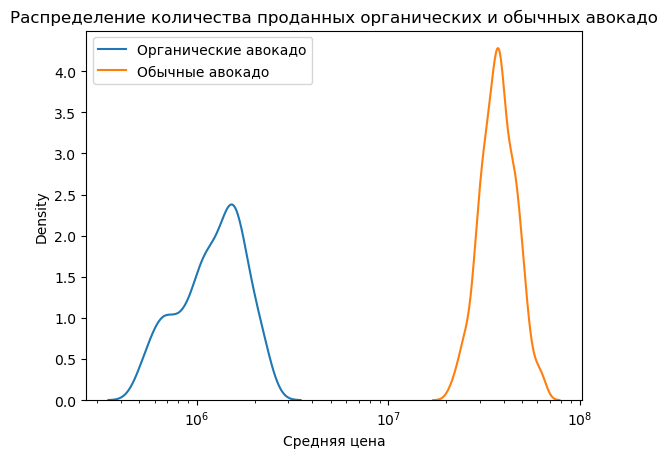

In [42]:
sns.kdeplot(organic.total_volume, label='Органические авокадо', log_scale=True)
sns.kdeplot(conventional.total_volume, label='Обычные авокадо', log_scale=True)
plt.legend()
plt.title('Распределение количества проданных органических и обычных авокадо')
plt.xlabel('Средняя цена')
plt.show()

In [43]:
solver(conventional.total_volume, organic.total_volume)

'Н0 отклоняем, средние, вероятно, разные.'

### Проверка третьей гипотезы
Калифорния закупает больше авокадо, чем Южная Каролина.

In [47]:
california = data_total_states[(data_total_states.geo == 'California') & 
                              (data_total_states.type_ != 'organic')]
south_carolina = data_total_states[(data_total_states.geo == 'South Carolina') & 
                           (data_total_states.type_ != 'organic')]

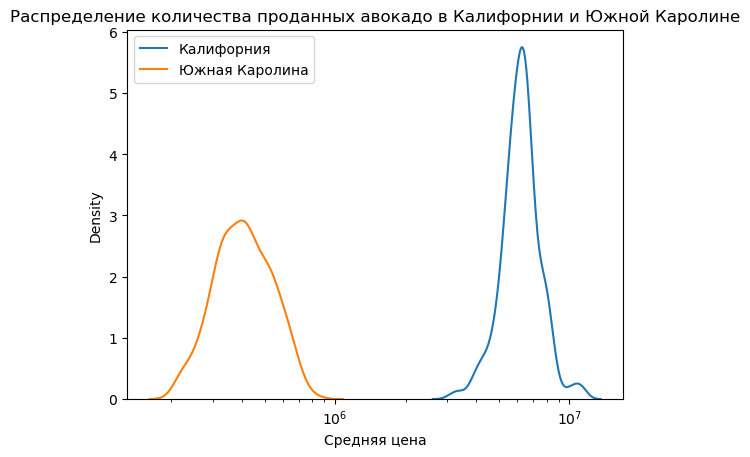

In [48]:
sns.kdeplot(california.total_volume, label='Калифорния', log_scale=True)
sns.kdeplot(south_carolina.total_volume, label='Южная Каролина', log_scale=True)
plt.legend()
plt.title('Распределение количества проданных авокадо в Калифорнии и Южной Каролине')
plt.xlabel('Средняя цена')
plt.show()

In [49]:
solver(california.total_volume, south_carolina.total_volume)

'Н0 отклоняем, средние, вероятно, разные.'

## Выводы

1. Средняя цена обычного авокадо за период 2015-2021 года варьировалась в диапазоне от 0.8 до 1.7 USD. При этом цена во времени изменялась с четкой периодичностью (падение цен в начале года и рост в конце).  
2. Динамика продаж обычного авокадо за период 2015-2021 года изменялась также с просматривающейся закономерностью (высокие продажи в начале года, низкие продажи к концу).  
3. Первая гипотеза о ценах в зимний и летний период: Н0 - отклонена, Н1 - не отклонена, то есть средняя цена обычного авокадо в зимний и летний период отличается.  
4. Вторая гипотеза о количестве проданых органических и обычных авокадо: Н0 - отклонена, Н1 - не отклонена, то есть обычный авокадо продается в большем количестве, чем органический. 
5. Третья гипотеза о количестве проданных обычных авокадо в Калифорнии и Южной Каролине: Н0 - отклонена, Н1 - не отклонена, то есть среднее количество закупаемых авокадо в Калифорнии отличается от количества в Южной Каролине. 